In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import scipy
import time
import torch

from scipy.stats import binom_test, wilcoxon
from tensorflow import keras

import sbibm

from sbibm.utils.io import get_tensor_from_csv, get_ndarray_from_csv
from sbi.analysis import pairplot
from utils import compile_df, huber_loss, mean_squared_error

In [2]:
# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

seed 223174


In [3]:
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

## Load benchmarking results

In [4]:
df = pd.concat([
    compile_df("../data/results/ddm-benchmarking/mnle/100-1000-trials/2021-10-25/11-01-18/"), # MNLE 100, 1000
    compile_df("../data/results/ddm-benchmarking/lan/100-1000-trials/2021-10-24/04-03-04/"), # LAN 100, 1000
])

# Exclude results for 1000-trial observations (observation indices > 300)
df.num_observation = df.num_observation.astype(int)
df = df[df.num_observation <=300]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
# get posterior sample mean and variance
N = 100
M = 10000
dim_parameters = 4
nle_samples = np.zeros((N, M, dim_parameters))
lan_samples = np.zeros((N, M, dim_parameters))
true_samples = np.zeros((N, M, dim_parameters))
true_params = np.zeros((N, dim_parameters))

for ii in range(N):
    # Offset to account for the fact that observations with 100 trials start at index 200
    obsi = ii + 1 + 200
    dd = df[df.num_observation==obsi]

    nle_samples[ii,] = get_ndarray_from_csv(dd[dd.algorithm=="NLE"].path.values[0]+"/posterior_samples.csv.bz2")
    lan_samples[ii,] = get_ndarray_from_csv(dd[dd.algorithm=="LAN-KDE"].path.values[0]+"/posterior_samples.csv.bz2")
    true_samples[ii,] = task.get_reference_posterior_samples(obsi).numpy()
    # get tho
    true_params[ii,] = task.get_true_parameters(obsi).numpy()

### Post-hoc calculate posterior metrics

In [6]:
meanerr = np.zeros((N, 2))
varerr = np.zeros_like(meanerr)
dispersion = np.zeros_like(meanerr)

meanerr[:, 1] = np.mean(abs(nle_samples.mean(-2) -true_samples.mean(-2)) / true_samples.std(-2), -1)
meanerr[:, 0] = np.mean(abs(lan_samples.mean(-2) -true_samples.mean(-2)) / true_samples.std(-2), -1)

dispersion[:, 1] = np.mean(abs(nle_samples.var(-2)) / true_samples.var(-2), -1)
dispersion[:, 0] = np.mean(abs(lan_samples.var(-2)) / true_samples.var(-2), -1)

varerr[:, 1] = np.mean(abs(nle_samples.var(-2) - true_samples.var(-2)) / true_samples.var(-2), -1)
varerr[:, 0] = np.mean(abs(lan_samples.var(-2) - true_samples.var(-2)) / true_samples.var(-2), -1)

### And add to data frame

In [7]:
df = df.sort_values(by=["num_observation", "algorithm"])
df.loc[:, "MEANERR"] = meanerr.reshape(-1)
df.loc[:, "VARERR"] = varerr.reshape(-1)
df.loc[:, "DISP"] = dispersion.reshape(-1)

### Load posterior samples

In [8]:
obs = 211
labels = ["LAN-KDE", "NLE"]
cols = ["MEANERR", "VARERR", "DISP", "C2ST"]
paths = []

# df = df100
for alg in labels:
    idx = df[df.num_observation==obs].algorithm == alg
    p = df[df.num_observation==obs].loc[idx, "path"].values
    [paths.append(pi) for pi in p]

ss = [
    sbibm.get_task("ddm").get_reference_posterior_samples(obs)
     ] + [get_ndarray_from_csv(path+"/posterior_samples.csv.bz2") for path in paths]

print(sbibm.get_task("ddm").get_true_parameters(obs))

tensor([[-0.1677,  1.2243,  0.4250,  1.1840]])


/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplo

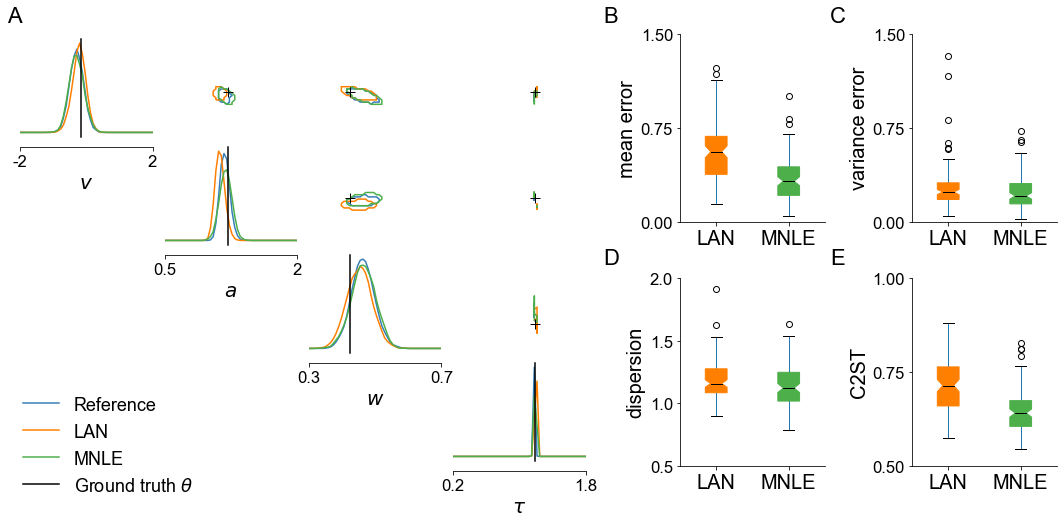

In [9]:
fig = plt.figure(figsize=(18, 8))
outer_grid = fig.add_gridspec(1, 2, wspace=0.2, hspace=0, width_ratios=[.6, .4])
# Plotting settings
notch = True
grid = False
box_widths = [0.3] * 2
showfliers = True

# posterior samples
num_plots = 4
inner_grid = outer_grid[0, 0].subgridspec(num_plots, num_plots, wspace=0.09, hspace=0)
ax1 = inner_grid.subplots()  # Create all subplots for the inner grid.
fix, ax1 = pairplot(ss, 
         points=sbibm.get_task("ddm").get_true_parameters(obs), 
         limits=[[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]], 
         ticks = [[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]], 
         samples_colors=colors[:3], 
         diag="kde",
         upper="contour",
         kde_offdiag=dict(bw_method="scott", bins=50),
         contour_upper=dict(levels=[0.1], percentile=False),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         fig=fig, 
         axes=ax1,
         labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"],
        );
plt.sca(ax1[0, 0])
plt.legend(["Reference", "LAN", "MNLE", r"Ground truth $\theta$"], 
           bbox_to_anchor=(-.1, -2.2), 
           loc=2)

# posterior metrics
inner_grid = outer_grid[0, 1].subgridspec(2, 2, wspace=.6, hspace=.3, )
ax2 = inner_grid.subplots()  # Create all subplots for the inner grid.

bdict = df.boxplot(ax=ax2, column=cols, by=["algorithm"], rot=0, 
                grid=grid, 
                patch_artist=True,
                widths=box_widths,
                return_type="both", medianprops={"color": "k"}, 
                notch=notch, 
                showfliers=showfliers,);

ticks = [
    np.linspace(0, 1.5, 3), 
    np.linspace(0, 1.5, 3),
    np.linspace(0.5, 2, 4), 
    np.linspace(0.5, 1.0, 3),
]

for a, t in zip(ax2.reshape(-1), ticks):
    a.set_yticks(t)
    a.set_ylim(t[0], t[-1])


for row_key, (axi,row) in bdict.iteritems():
    for i,box in enumerate(row['boxes']):
        box.set_color(colors[i+1])
        
col_labels = ["mean error", "variance error", "dispersion", "C2ST"]

for i, a in enumerate(ax2.reshape(-1)):
    a.set_ylabel(col_labels[i])
    a.set_title("")
    a.set_ylabel(col_labels[i])
    a.set_xlabel("")
    a.set_xticklabels(["LAN", "MNLE"], fontsize=mpl.rcParams["font.size"])
plt.suptitle("")

weight = "regular"
fontsize = 22
y1 = 0.92
x1 = 0.09
dx = 0.635
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.46, y1, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.46, y1 - 0.42, "D", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1 - 0.42, "E", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("figures/Figure3-MNLE-LAN-posterior-comparison.png", dpi=300, bbox_inches="tight");

### Medians and pairwise comparison tests as report in the paper

In [10]:
df.groupby("algorithm").MEANERR.median()

algorithm
LAN-KDE    0.558180
NLE        0.322775
Name: MEANERR, dtype: float64

In [11]:
df.groupby("algorithm").VARERR.median()

algorithm
LAN-KDE    0.236382
NLE        0.205053
Name: VARERR, dtype: float64

In [12]:
df.groupby("algorithm").DISP.median()

algorithm
LAN-KDE    1.157253
NLE        1.121455
Name: DISP, dtype: float64

In [13]:
df.groupby("algorithm").C2ST.median()

algorithm
LAN-KDE    0.713675
NLE        0.640425
Name: C2ST, dtype: float64

### Sign test whether MNLE or LAN has smaller mean error

In [14]:
smaller_err = (df[df.algorithm=="LAN-KDE"].MEANERR.values < df[df.algorithm=="NLE"].MEANERR.values).sum()
smaller_err, binom_test(smaller_err, 100, 0.5)

(24, 1.810002621302925e-07)

In [15]:
smaller_err = (df[df.algorithm=="LAN-KDE"].VARERR.values < df[df.algorithm=="NLE"].VARERR.values).sum()
smaller_err, binom_test(smaller_err, 100, 0.5)

(42, 0.13321061920721353)

### Sign test wether MNLE or LAN has closer to 1 dispersion

In [16]:
ct1 = (np.abs(df[df.algorithm=="LAN-KDE"].DISP.values - 1) < 
       np.abs(df[df.algorithm=="NLE"].DISP.values - 1)).sum()
ct1, binom_test(ct1, 100, 0.5)

(42, 0.13321061920721353)

### Sign test for smaller c2st

In [17]:
smallerc2st = (df[df.algorithm=="LAN-KDE"].C2ST.values < df[df.algorithm=="NLE"].C2ST.values).sum()
smallerc2st, binom_test(smallerc2st, 100, 0.5)

(19, 2.7027625220487873e-10)

# Figure 4: posterior calibration

In [18]:
L = 1000
ranks = np.zeros((N, 4, 3)) # 4 params, 3 methods

for obsi in range(N):
    # rank tho under samples
    ranks[obsi, :, 0] = (true_samples[obsi, :L, ] < true_params[obsi,]).sum(0)
    ranks[obsi, :, 1] = (lan_samples[obsi, :L, ] < true_params[obsi,]).sum(0)
    ranks[obsi, :, 2] = (nle_samples[obsi, :L, ] < true_params[obsi,]).sum(0)

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


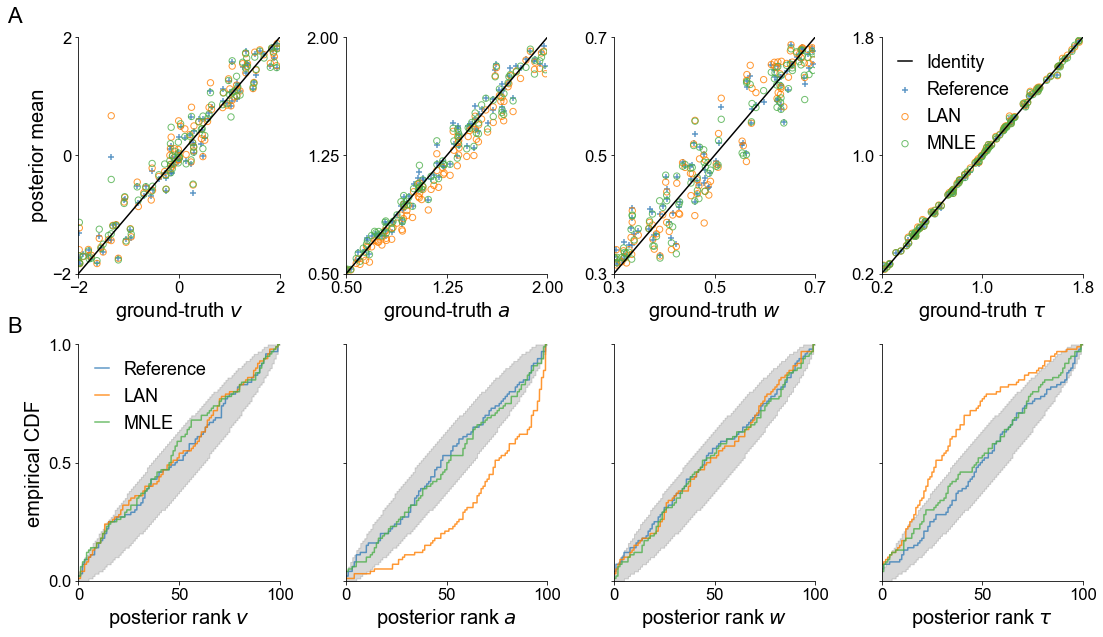

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10), 
                      gridspec_kw=dict(wspace=0.33, hspace=0.3))
# mpl.rcParams["legend.fontsize"] = 16
parameter_labels = [r"$v$", r"$a$", r"$w$", r"$\tau$"]
s = 40
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]

for ii in range(4):
    # actual GT params
    truth = true_params[:, ii]
    plt.sca(ax[0, ii])
    plt.scatter(truth, true_samples.mean(1)[:, ii], s=s, color=colors[0], 
                    label=fr"Reference",            
                    alpha=alpha,
#                     facecolors='none'
                    marker="+",
                   )
    plt.scatter(truth, lan_samples.mean(1)[:, ii], s=s, color=colors[1], 
#                 label=fr"LAN, $R^2={np.corrcoef(truth, lan_samples.mean(1)[:, ii])[0, 1]**2:.2f}$",
                label=fr"LAN",            
                alpha=alpha,
                facecolors="none",
               )
    plt.scatter(truth, nle_samples.mean(1)[:, ii], s=s, color=colors[2], 
#                 label=fr"NLE, $R^2={np.corrcoef(truth, nle_samples.mean(1)[:, ii])[0, 1]**2:.2f}$",
                label=fr"MNLE",
                alpha=alpha,      
                facecolors="none",
               )
    plt.plot(np.linspace(limits[ii][0], limits[ii][1], 100), 
             np.linspace(limits[ii][0], limits[ii][1], 100), color="k", label="Identity")
    plt.ylim(limits[ii])
    plt.yticks(np.linspace(limits[ii][0], limits[ii][1], 3))

    plt.xlim(limits[ii])
    plt.xticks(np.linspace(limits[ii][0], limits[ii][1], 3))
    plt.xlabel("ground-truth " + parameter_labels[ii])
#     plt.ylabel([r"$\hat{v}$", r"$\hat{a}$", r"$\hat{w}$", r"$\hat{\tau}$"][ii])
    if ii == 0:
        plt.ylabel("posterior mean")
    if ii==3:
        plt.legend(loc=2, handlelength=0.8);

repeats = 50
nbins = 100
from scipy.stats import binom

for ii in range(3):
    for jj in range(4):
        plt.sca(ax[1, jj])
        hist, *_ = np.histogram(ranks[:, jj, ii], bins=nbins, density=False)
        histcs = hist.cumsum()
        plt.plot(np.linspace(0, nbins, repeats*nbins), 
                 np.repeat(histcs / histcs.max(), repeats), 
        #          label=labels[i], 
                 color=colors[ii], 
                 alpha=0.8)
        if jj==0:
            plt.yticks(np.linspace(0, 1, 3))
            plt.ylabel("empirical CDF")
            plt.legend(["Reference", "LAN", "MNLE"], loc=2, handlelength=0.8)
        else:
            plt.yticks(np.linspace(0, 1, 3), [])
        plt.ylim(0, 1)
        plt.xlim(0, nbins)
        plt.xticks(np.linspace(0, nbins, 3))
        plt.xlabel("posterior rank "+parameter_labels[jj])
        if ii==0:
            # Construct uniform histogram.
            hb = binom(N, p=1 / nbins).ppf(0.5) * np.ones(nbins)
            hbb = hb.cumsum() / hb.sum()

            lower = [binom(N, p=p).ppf(0.005) for p in hbb]
            upper = [binom(N, p=p).ppf(0.995) for p in hbb]

            # Plot grey area with expected ECDF.
            plt.fill_between(x=np.linspace(0, nbins, repeats*nbins), 
                         y1=np.repeat(lower / np.max(lower), repeats), 
                         y2=np.repeat(upper / np.max(lower), repeats), 
                         color="grey", 
                         alpha=0.3)
weight = "regular"
fontsize = 22
y1 = 0.9
x1 = 0.07
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1 - 0.43, "B", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("figures/Figure4-MNLE-LAN-posterior-calibration.png", dpi=300, bbox_inches="tight");